In [3]:
import os
import json
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations 

DIGIT_MAPPING = {
    0: 'zero',
    1: 'one',
    2: 'two',
    3: 'three',
    4: 'four',
    5: 'five',
    6: 'six',
    7: 'seven',
    8: 'eight',
    9: 'nine'
}

In [2]:
def parse_result(path):
    line_list = open(path,'r').readlines()
    lines = [line.strip() for line in line_list]
    end_line = lines[-1].split(', ')
    best_eer = end_line[-1].split(' ')[-1]
    result = {}
    sum_minDCF = 0
    for i,line in enumerate(lines):
        try:
            cur_eer = line.split(', ')[-2].split(' ')[-1]
            cur_best_eer = line.split(', ')[-1].split(' ')[-1]
            if cur_eer == cur_best_eer == best_eer:
                for j in range(i-2,i):
                    splits = lines[j].split(', ')
                    gender = splits[0].split(' ')[-1]
                    eer = splits[1].split(' ')[-1]
                    minDCF = splits[2].split(' ')[-1]
                    result[gender] = {'eer': float(eer.split('%')[0]), 'minDCF': float(minDCF)}
                    sum_minDCF += float(minDCF)
        except :
            pass
    result['overall'] = {'eer': float(best_eer.split('%')[0]), 'minDCF': sum_minDCF/2}
    return result


In [4]:
LOOP = 5

In [4]:
for l in range(LOOP):
    files = glob.glob('./checkpoints_combine/exp3/loop%s/*/score-stage.txt'%(l+1))
    for file in files:
        result = parse_result(file)
        index = file.rfind('/')
        path = file[:index]
        name = 'dev_results.json'
        with open(os.path.join(path, name), 'w') as f:
            json.dump(result,f)

In [21]:
def concate_result(files, loop, store=False):
    data = {
        'phase': [],
        'eer': [],
        'gender': [],
        'minDCF': [],
        'text': [],
        'loop': [],
        'word': []
        }
    parse = files[0].split('/')
    path = '/'.join(parse[:-2])
    for file in files:
        res = json.load(open(file, 'r'))
        splits = file.split('/')
        if 'eval' in splits[-1]:
            phase = 'eval'
        if 'dev' in splits[-1]:
            phase = 'dev'
        if 'all' in splits[-1]:
            phase ='eval'
        text = splits[-2]
        word = text.split('_')[0]
        
        for g in res:
            data['gender'].append(g)
            data['eer'].append(res[g]['eer'])
            data['minDCF'].append(res[g]['minDCF'])
            data['phase'].append(phase)
            data['text'].append(text)
            data['loop'].append(loop)
            data['word'].append(word)
    df = pd.DataFrame(data)
    if store:
        save_path = os.path.join(path, 'all_eval_results.csv')
        print('Save result to %s' % (save_path))
        df.to_csv(save_path, index=False)
    return df

In [22]:
for l in [0,1,2,3,4]:
    # if l == 0:
    #     result_files = glob.glob('checkpoints/non_pretrained/channel_1024_old/exp3/loop%s/*/all_results.json' %(l+1))
    #     # + glob.glob('vox_result/loop%s/*/all_eval_results_experiment_no_tw.json' %(l+1))
    #     df = concate_result(result_files,l+1,store=True)
    # else:
        result_files = glob.glob('checkpoints/non_pretrained/channel_128/exp1/loop%s/*/all_eval_result.json' %(l+1))
        # + glob.glob('vox_result/loop%s/*/all_eval_results_experiment_no_tw.json' %(l+1))
        df = concate_result(result_files,l+1,store=True)

Save result to checkpoints/non_pretrained/channel_128/exp1/loop1/all_eval_results.csv
Save result to checkpoints/non_pretrained/channel_128/exp1/loop2/all_eval_results.csv
Save result to checkpoints/non_pretrained/channel_128/exp1/loop3/all_eval_results.csv
Save result to checkpoints/non_pretrained/channel_128/exp1/loop4/all_eval_results.csv
Save result to checkpoints/non_pretrained/channel_128/exp1/loop5/all_eval_results.csv


In [26]:
for l in [0]:
    result_files = glob.glob('pretrained_checkpoints/exp3/loop%s/*/all_eval_results_real_data_and_fake_data_no_tuning.json'%(l+1))
    df = concate_result(result_files,l+1,store=True)

Save result to non_pretrained_checkpoints/exp1/loop1/all_eval_results_no_tw.csv
Save result to non_pretrained_checkpoints/exp1/loop2/all_eval_results_no_tw.csv
Save result to non_pretrained_checkpoints/exp1/loop3/all_eval_results_no_tw.csv
Save result to non_pretrained_checkpoints/exp1/loop4/all_eval_results_no_tw.csv
Save result to non_pretrained_checkpoints/exp1/loop5/all_eval_results_no_tw.csv


In [16]:
result_files = glob.glob('pruning_checkpoints/exp1/loop2_experiments/*/all_eval_result.json')
df = concate_result(result_files,2,store=True)

Save result to pruning_checkpoints/exp1/loop2_experiments/all_eval_results.csv


In [5]:
df

,phase,eer,gender,minDCF,text,loop,word
0,eval,8.180000,female,0.746901,9_1,2,9
1,eval,8.490000,male,0.689423,9_1,2,9
2,eval,8.514667,all,0.703438,9_1,2,9
3,eval,10.146667,female,0.774986,9_6,2,9
4,eval,11.970000,male,0.858905,9_6,2,9
5,eval,11.728000,all,0.841122,9_6,2,9
6,eval,11.800000,female,0.852294,1_6,2,1
7,eval,12.646667,male,0.869589,1_6,2,1
8,eval,12.446667,all,0.859916,1_6,2,1
9,eval,9.156463,female,0.715947,1_9,2,1


In [9]:
def plot_result(df_all, gender, phase, loop):
    import matplotlib.pyplot as plt
    result = df_all[(df_all['phase'] == phase) & (df_all['gender'] == gender)].sort_values('word')
    # print(result) 
    text = [str(x) for x in range(0,10)]
    plt.figure(figsize=(12,6))
    plt.suptitle('%s - Iteration %s' % (gender, loop))

    plt.subplot(1,2,1)
    plt.bar(text, result['minDCF'],0.4, label='minDCF')
    plt.xticks(ticks=text)
    plt.xlabel('Text')
    plt.ylabel('minDCF')
    
    plt.subplot(1,2,2)
    plt.bar(text, result['eer'],0.4, label='EER')
    plt.xticks(ticks=text)
    plt.xlabel('Text')
    plt.ylabel('EER (%)')
    plt.show()
    

In [2]:
def get_result(data,max_loop=3):
    result = {
    }
    genders = ['female', 'male', 'all']
    phases = ['eval']
    words = [x for x in range(0,10)]
    for phase in phases:
        result[phase] = {}
        for gender in genders:
            result[phase][gender] = {
                'eer': {},
                'minDCF': {},
            }
            for word in words:
                df = data[(data['phase'] == phase) & (data['gender'] == gender) & (data['word']==word)]
                # print(data['word'])
                # print(df)
                result[phase][gender]['eer'][word] = df['eer'].to_list()
                result[phase][gender]['minDCF'][word] = df['minDCF'].to_list()
    return result

                

    

In [13]:
def get_result_2(data,max_loop=3):
    result = {
    }
    genders = ['female', 'male', 'all']
    phases = ['eval']
    # words = [x for x in range(0,10)]
    from itertools import permutations
    words = list(permutations(['9', '6', '3', '0','1'],r=2))
    words = ['_'.join(list(pair)) for pair in words]
    for phase in phases:
        result[phase] = {}
        for gender in genders:
            result[phase][gender] = {
                'eer': {},
                'minDCF': {},
            }
            for word in words:
                df = data[(data['phase'] == phase) & (data['gender'] == gender) & (data['word']==word)]
                # print(data['word'])
                # print(df)
                result[phase][gender]['eer'][word] = df['eer'].to_list()
                result[phase][gender]['minDCF'][word] = df['minDCF'].to_list()
    return result


In [ ]:
result = get_result_2()

In [30]:
json.dump(result, open('experiment_checkpoints/result_evals_tuning_2.json', 'w'))

In [23]:
df_all = pd.DataFrame()
MAX_LOOP = 5
for loop in range(1,MAX_LOOP+1):
    # if loop == 1:
    #     df_all = pd.concat([df_all, pd.read_csv('checkpoints/pretrained/channel_1024/exp1/loop%s/all_eval_results_tuning_2.csv'%(loop))], ignore_index=True)
    # else:
        df_all = pd.concat([df_all, pd.read_csv('checkpoints/non_pretrained/channel_128/exp1/loop%s/all_eval_results.csv'%(loop))], ignore_index=True)
result = get_result(df_all, max_loop=1)

In [24]:
df_all

,phase,eer,gender,minDCF,text,loop,word
0,eval,14.054422,female,0.575442,0,1,0
1,eval,7.283333,male,0.425348,0,1,0
2,eval,9.227211,all,0.636539,0,1,0
3,eval,8.748299,female,0.397863,3,1,3
4,eval,10.268707,male,0.484349,3,1,3
...,...,...,...,...,...,...,...
145,eval,1.326531,male,0.086290,0_0_0_0_0,5,0
146,eval,2.213333,all,0.126910,0_0_0_0_0,5,0
147,eval,2.217687,female,0.147790,9_9_9_9_9,5,9
148,eval,1.546667,male,0.124842,9_9_9_9_9,5,9


In [25]:
df_all.to_csv('sync_result/non_pretrain/128_non-pretrained_exp1.csv', index=False)

In [27]:
json.dump(result, open('sync_result/non_pretrain/128_non-pretrained_exp1.json', 'w'))

In [59]:
def show_result(result, metric='eer',all=False, start_loop=1, end_loop=5):
    if all:
        genders = ['overall']
    else:
        genders =  ['female','male','all']
    for gender in genders:
        # plt.figure(figsize=(12,4))
        name_set = list(result.keys())
        a = []
        # for v in result['dev'][gender][metric].values():
        #     a.extend(v)
        for v in result['eval'][gender][metric].values():
            a.extend(v)
        if len(a) == 0:
            continue
        min_ = min(a)
        max_ = max(a)
        for idx,set in enumerate(name_set):
            ax = plt.subplot(len(name_set),1,idx+1)
            set_result = result[set]
            for i in range(0,10):
                try:
                    ax.plot([j for j in range(start_loop, end_loop+1)],set_result[gender][metric][i])
                except:
                    ax.plot([j for j in range(start_loop, end_loop+1)],set_result[gender][metric][str(i)])

            # box = ax.get_position()
            # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
            plt.xticks([ i for i in range(start_loop,end_loop+1)])
            plt.xlabel('The times of iteration')
            plt.ylim((min_-1,max_+1))
            plt.ylabel('EER (%)')
            plt.title(gender.capitalize())
        plt.legend([DIGIT_MAPPING[i] for i in range(0,10)], loc='upper right', bbox_to_anchor=(1.15, 1))
        # plt.savefig('results/output_exp1_%s.png'%(gender))

In [119]:
result = {}
# result['0'] = json.load(open('real_data_result/fake/real_data_and_fake_data_tuning_loop1.json', 'r'))
result['1'] = json.load(open('sync_result/pretrain/1024_pretrained_exp1.json', 'r'))
result['2'] = json.load(open('sync_result/pretrain/1024_pretrained_exp2.json', 'r'))
result['3'] = json.load(open('sync_result/pretrain/1024_pretrained_exp3.json', 'r'))


In [121]:
MAX_LOOP = 5
phases = ['eval']
metrics = ['eer', 'minDCF']
genders = ['female', 'male', 'all']
final_result = {}
# word = {}
for phase in phases:
    final_result[phase] = {}
    # word[phase] = {}
    for gender in genders:
        final_result[phase][gender] = {}
        # word[phase][gender] = {}
        for metric in metrics:
            final_result[phase][gender][metric] = {}
            # word[phase][gender][metric] = {}
            for i in range(0,10):
                temp = []
                for exp in result:
                    if exp == '0':
                        continue
                    temp.append(result[exp][phase][gender][metric][str(i)][:MAX_LOOP])
                value = np.mean(temp, axis=0)
                final_result[phase][gender][metric][i] = list(value)
                # final_result[phase][gender][metric][i] = result['0'][phase][gender][metric][str(i)] + list(value)
                # word[phase][gender][metric][i] = value[0]






In [122]:
final_results = final_result

In [123]:
start_loop = 1
end_loop = 5
genders =  ['female', 'male', 'all']
metric = 'eer'

for num, final_result in enumerate(final_result):
    # fig = plt.figure(figsize=(20,4))
    # plt.subplots_adjust(left=0.1,
    #                     bottom=0.1,
    #                     right=0.8,
    #                     top=1.5,
    #                     wspace=0.2,
    #                     hspace=0.4)
    # spec = fig.add_gridspec(2, 2)
    a = []
    for gender in genders:
        for v in final_result['eval'][gender][metric].values():
                a.extend(v)
        if len(a) == 0:
            continue
        min_ = min(a)
        max_ = max(a)

    for _, gender in enumerate(genders):
        # plt.figure(figsize=(12,4))
        name_set = list(final_result.keys())
        # for v in result['dev'][gender][metric].values():
        #     a.extend(v)
        # if gender=='all':
            # ax = plt.subplot2grid((2,4),(1,1), colspan=2)
        # ax = fig.add_subplot(2,3,i + 1)
        fig = plt.figure(figsize=(8,4))
        ax = fig.add_subplot(111)
            # ax.set_adjustable('box'=[1.5,1.5,6,4])
        # if gender == 'female':
            # ax = plt.subplot2grid((2,4),(0,0), colspan=2)
        # fig = plt.figure(figsize=(12,6))
        # ax = fig.add_subplot(111)
        
        # if gender == 'male':
            # ax = plt.subplot2grid((2,4),(0,2), colspan=2)
        for idx,set in enumerate(name_set):
            set_result = final_result[set]
            # print(set_result[gender][metric])
            for i in range(0,10):
                try:
                    ax.plot([j for j in range(start_loop, end_loop+1)],set_result[gender][metric][i])
                except:
                    ax.plot([j for j in range(start_loop, end_loop+1)],set_result[gender][metric][str(i)])

            # box = ax.get_position()
            # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.set_xticks([ i for i in range(start_loop,end_loop+1)])
        ax.set_xlabel('The number of repetitions')
        ax.set_ylim((min_-0.5,max_+0.5))
        if metric == 'eer':
            y_label = 'EER (%)'
        else:
            y_label = 'minDCF'

        ax.set_ylabel(y_label)
        ax.set_title(gender.capitalize())
        # ax.legend([DIGIT_MAPPING[i] for i in range(0,10)], loc='upper left', ncol=1, bbox_to_anchor=[1,1], title='Text')
        plt.legend([DIGIT_MAPPING[i] for i in range(0,10)], loc='upper left', ncol=1, bbox_to_anchor=[1,1], title='Text')
plt.show()

TypeError: string indices must be integers

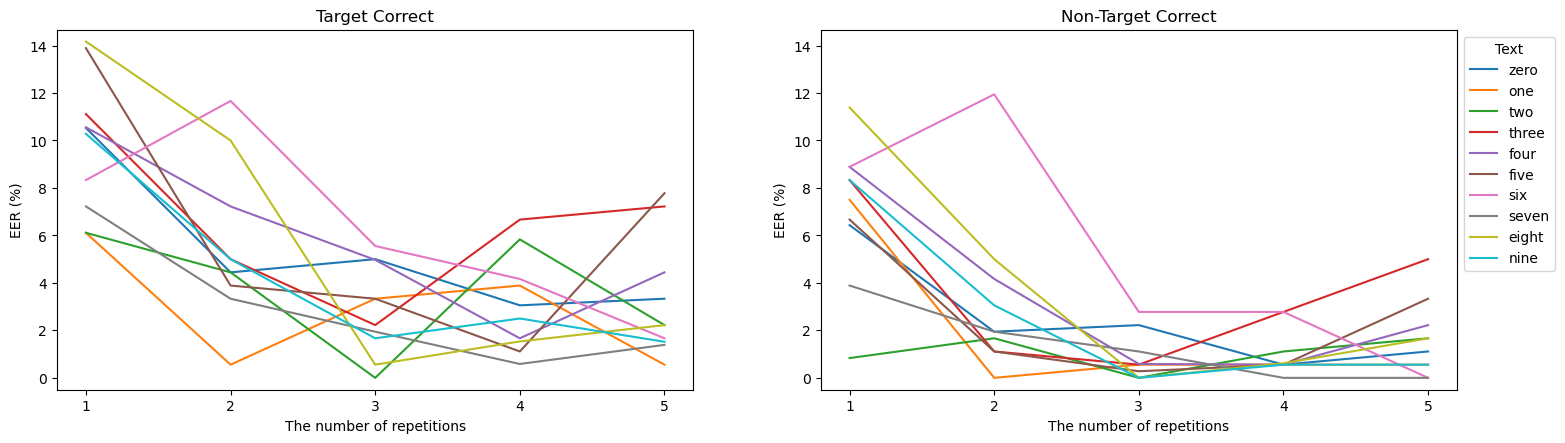

In [15]:
final_results = [#json.load(open('real_data_result/fake/real_data_and_fake_data_tuning.json', 'r'))]
                 json.load(open('pruning_checkpoints/exp1/results_on_real_data.json', 'r')),
                 json.load(open('pruning_checkpoints/exp1/results_on_real_data_no_tw.json', 'r'))]
result_labels = ['Target Correct', 'Non-Target Correct']
start_loop = 1
end_loop = 5
genders =  ['male']
metric = 'eer'

a = []
for final_result in final_results:
    
    for gender in genders:
        for v in final_result['eval'][gender][metric].values():
                a.extend(v)
        if len(a) == 0:
            continue
        min_ = min(a)
        max_ = max(a)
fig = plt.figure(figsize=(20,4))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.8,
                    top=1,
                    wspace=0.2,
                    hspace=0.4)
# spec = fig.add_gridspec(2, 2)
for case_idx, final_result in enumerate(final_results):
    ax = fig.add_subplot(1,2,case_idx+1)
    for i, gender in enumerate(genders):
        # plt.figure(figsize=(12,4))
        name_set = list(final_result.keys())
        # for v in result['dev'][gender][metric].values():
        #     a.extend(v)
        # if gender=='all':
            # ax = plt.subplot2grid((2,4),(1,1), colspan=2)
        # 
            # ax.set_adjustable('box'=[1.5,1.5,6,4])
        # if gender == 'female':
            # ax = plt.subplot2grid((2,4),(0,0), colspan=2)
        # fig = plt.figure(figsize=(12,6))
        # ax = fig.add_subplot(111)
        
        # if gender == 'male':
            # ax = plt.subplot2grid((2,4),(0,2), colspan=2)
        for idx,set in enumerate(name_set):
            set_result = final_result[set]
            # print(set_result[gender][metric])
            for i in range(0,10):
                try:
                    ax.plot([j for j in range(start_loop, end_loop+1)],set_result[gender][metric][i])
                except:
                    ax.plot([j for j in range(start_loop, end_loop+1)],set_result[gender][metric][str(i)])

            # box = ax.get_position()
            # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.set_xticks([ i for i in range(start_loop,end_loop+1)])
        ax.set_xlabel('The number of repetitions')
        ax.set_ylim((min_-0.5,max_+0.5))
        if metric == 'eer':
            y_label = 'EER (%)'
        else:
            y_label = 'minDCF'

    ax.set_ylabel(y_label)
    ax.set_title(result_labels[case_idx])
# plt.legend([DIGIT_MAPPING[i] for i in range(0,10)], loc='lower center', ncol=1, bbox_to_anchor=[0.5,-0.5], title='Text')
ax.legend([DIGIT_MAPPING[i] for i in range(0,10)], loc='upper left', ncol=1, bbox_to_anchor=[1,1], title='Text')
plt.show()

# Compare 6-6 to other

In [40]:
from itertools import permutations 
df_all = pd.DataFrame()
# files = glob.glob('experiment_checkpoints/*/all_eval_results_tuning_2.csv')
files = glob.glob('checkpoints/pretrained/channel_1024_new_data/experiment_checkpoints/exp3/all_eval_results_new_data_2.csv')
for file in files:
    df_all = pd.concat([df_all, pd.read_csv(file)], ignore_index=True)
result = {
    }
genders = ['female', 'male', 'all']
phases = ['eval']
words = list(permutations(['9', '6', '3', '0','1'],r=2))
for phase in phases:
    result[phase] = {}
    for gender in genders:
        result[phase][gender] = {
            'eer': {},
            'minDCF': {},
        }
        for word in words:
            text = [str(w) for w in word]
            text = '_'.join(text)
            df = df_all[(df_all['phase'] == phase) & (df_all['gender'] == gender) & (df_all['text']==text)]
            # print(data['word'])
            result[phase][gender]['eer'][text] = np.mean(df['eer'].to_list())
            result[phase][gender]['minDCF'][text] = np.mean(df['minDCF'].to_list())


In [41]:
result

{'eval': {'female': {'eer': {'9_6': 11.034013605442173,
    '9_3': 11.142857142857142,
    '9_0': 12.34013605442177,
    '9_1': 10.7,
    '6_9': 11.306666666666668,
    '6_3': 9.551020408163268,
    '6_0': 10.713333333333331,
    '6_1': 11.153333333333332,
    '3_9': 10.312925170068032,
    '3_6': 9.795918367346934,
    '3_0': 13.54,
    '3_1': 10.126666666666669,
    '0_9': 11.933333333333334,
    '0_6': 9.666666666666666,
    '0_3': 12.0,
    '0_1': 15.40136054421769,
    '1_9': 9.401360544217685,
    '1_6': 11.700680272108844,
    '1_3': 9.98639455782313,
    '1_0': 12.2},
   'minDCF': {'9_6': 0.8394666666666665,
    '9_3': 0.8687496598639463,
    '9_0': 0.8447129251700691,
    '9_1': 0.841632653061224,
    '6_9': 0.8697591836734692,
    '6_3': 0.7633088435374141,
    '6_0': 0.7772380952380947,
    '6_1': 0.8551741496598644,
    '3_9': 0.8922326530612252,
    '3_6': 0.7648761904761894,
    '3_0': 0.8441183673469393,
    '3_1': 0.9044585034013604,
    '0_9': 0.8910013605442176,
    '

In [42]:
json.dump(result, open('sync_result/pretrain/1024_experiment_exp3.json','w'))

In [16]:
final_results = json.load(open('pruning_checkpoints/exp1/results_loop1_loop5.json', 'r'))

In [24]:

# array = []
# for i in range(0,10):
#     temp = []
#     for gender in ['female','male','all']:
#         temp.append(final_result['eval'][gender]['eer'][str(i)][0])
#     array.append(temp)
#     print(temp)
# avg = np.mean(array,axis=1)
# avg # 1 3 6 9

[6.1, 6.894557823129254, 7.725333333333332]
[10.413333333333332, 7.734693877551024, 8.512]
[7.795918367346943, 10.26, 9.652]
[6.453333333333333, 8.670068027210887, 8.265333333333333]
[10.612244897959188, 8.596666666666666, 9.014965986394564]
[9.866666666666667, 6.1033333333333335, 7.219047619047614]
[5.28, 7.47959183673469, 7.257333333333333]
[4.217687074829934, 8.163265306122447, 8.114285714285717]
[6.013605442176873, 8.860544217687071, 8.6]
[7.813333333333333, 6.180272108843532, 6.864000000000001]


array([6.90663039, 8.88667574, 9.23597279, 7.7962449 , 9.40795918,
       7.72968254, 6.67230839, 6.83174603, 7.82471655, 6.95253515])

In [25]:
# dir = {}
# for i in range(len(avg)):
#     dir[i] = avg[i]
# {k: v for k, v in sorted(dir.items(), key=lambda item: item[1])}

{6: 6.672308390022674,
 7: 6.831746031746033,
 0: 6.906630385487529,
 9: 6.952535147392289,
 5: 7.729682539682538,
 3: 7.796244897959184,
 8: 7.824716553287981,
 1: 8.886675736961452,
 2: 9.235972789115648,
 4: 9.407959183673473}

In [11]:
# final_result = json.load(open('final_results/average_pretrained_diff_index.json', 'r'))
# final_result = json.load(open('vox_result/results_no_tw_loop1_loop5.json', 'r'))

In [27]:
keys = ['0','1', '3', '6', '9']
filter = {}
for gender in ['female', 'male', 'all']:
    filter[gender] = {} 
    filter[gender]['eer'] = {}
    filter[gender]['minDCF'] = {}
    for digit in keys:
        filter[gender]['eer'][digit + '_' + digit] = final_result['eval'][gender]['eer'][digit][1]
        filter[gender]['minDCF'][digit +  '_' + digit] = final_result['eval'][gender]['minDCF'][digit][1]

In [28]:
filter

{'female': {'eer': {'0_0': 2.380952380952384,
   '1_1': 2.286666666666666,
   '3_3': 1.2733333333333332,
   '6_6': 0.6530612244897926,
   '9_9': 2.204081632653065},
  'minDCF': {'0_0': 0.1198585034013604,
   '1_1': 0.1550911564625847,
   '3_3': 0.0607877551020416,
   '6_6': 0.04711156462585,
   '9_9': 0.1826285714285719}},
 'male': {'eer': {'0_0': 2.305,
   '1_1': 3.235,
   '3_3': 3.663265306122454,
   '6_6': 2.1802721088435395,
   '9_9': 2.2333333333333334},
  'minDCF': {'0_0': 0.1729724489795909,
   '1_1': 0.1925993197278911,
   '3_3': 0.1969965986394561,
   '6_6': 0.1590428571428562,
   '9_9': 0.1372023809523808}},
 'all': {'eer': {'0_0': 2.7129251700680257,
   '1_1': 3.8866666666666663,
   '3_3': 3.264,
   '6_6': 2.0326530612244875,
   '9_9': 2.4979591836734705},
  'minDCF': {'0_0': 0.1765140136054428,
   '1_1': 0.2441349659863937,
   '3_3': 0.1716650340136045,
   '6_6': 0.1352160544217691,
   '9_9': 0.1713817687074821}}}

In [29]:
for gender in ['female', 'male', 'all']:
    filter[gender]['eer'].update(result['eval'][gender]['eer'])
    filter[gender]['minDCF'].update(result['eval'][gender]['minDCF'])
    

In [36]:
# filter = json.load(open('pretrained_checkpoints/word_final.json','r'))['eval']
# filter = json.load(open('vox_result/results_no_tw_loop1_loop5.json','r'))['eval']
# filter = json.load(open('non_pretrained_checkpoints/word_final.json','r'))['eval']
# data_vis = dict(sorted(filter[gender][metric].items(), key=lambda item: item[1]))
# data_vis

In [49]:
filter = json.load(open('pruning_checkpoints/exp1/word_final.json', 'r'))
filter = filter['eval']

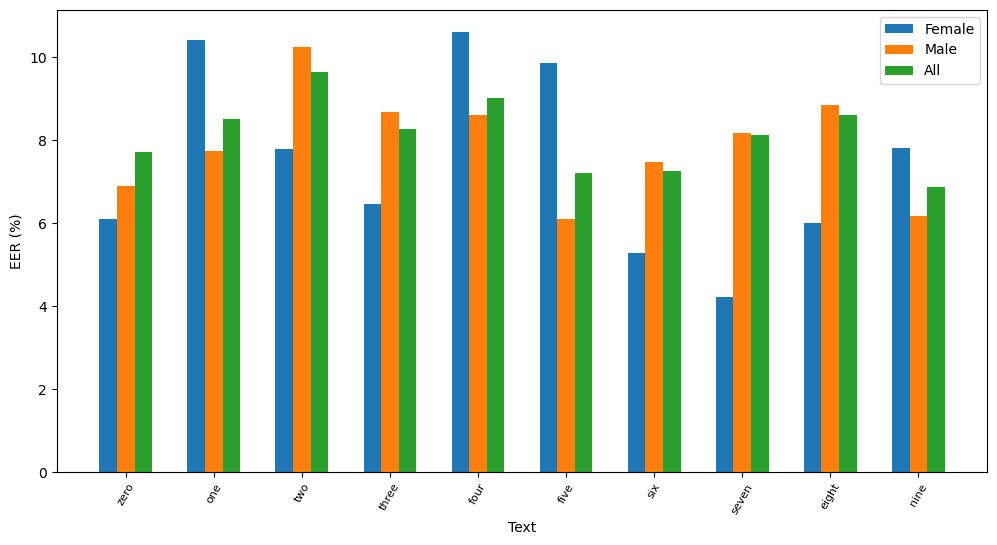

In [50]:
param = [-0.2, 0, +0.2]
plt.figure(figsize=(12,6))
# data_vis = dict(sorted(filter[gender][metric].items(), key=lambda item: item[1]))
plt.bar(np.arange(len(filter['female']['eer'])) - 0.2, list(filter['female']['eer'].values()),width=0.2)
plt.bar(np.arange(len(filter['male']['eer'])), list(filter['male']['eer'].values()),width=0.2)
plt.bar(np.arange(len(filter['all']['eer']))  +0.2, list(filter['all']['eer'].values()),width=0.2)
plt.xlabel('Text')
plt.ylabel('EER (%)')
plt.legend(['Female', 'Male', 'All'])
plt.xticks(ticks=range(len(filter['female']['eer'])),labels=[ '_'.join([DIGIT_MAPPING[int(i)] for i in text.split('_')]) for text in list(filter['female']['eer'].keys())],fontsize=8, rotation=60)
plt.show()
        # plt.savefig('experiment_checkpoints/%s.png' % (gender))

In [31]:
json.dump(filter, open('pruning_checkpoints/exp1/loop2_experiments/result_final.json', 'w'))

In [4]:
metrics = ['eer', 'minDCF']
words = ['6', '6_6']
result = {}
for gender in ['male','female','all']:
    result[gender] = {}
    for w in words:
        files = glob.glob('real_test/%s_*.json'%(w))
        if len(files) > 0:
            sum_eer = 0
            sum_minDCF = 0
            for file in files:
                scores = json.load(open(file))
                sum_eer += scores[gender]['eer']
                sum_minDCF += scores[gender]['minDCF']
            avg_eer = sum_eer / len(files)
            avg_minDCF = sum_minDCF / len(files)
            result[gender][w] = {'eer': avg_eer, 'minDCF':avg_minDCF}

# Diff

In [72]:
results = {
    '1024': json.load(open('final_results/average_pretrained_diff_index.json')),
    '128': json.load(open('pruning_checkpoints/exp1/results_loop1_loop5.json'))
}

In [73]:
data = {
    'female':{},
    'male':{},
    'all':{}
}
for gender in ['female', 'male', 'all']:
    for digit in range(0,10):
        loss = np.array(results['1024']['eval'][gender]['eer'][str(digit)]) - np.array(results['128']['eval'][gender]['eer'][str(digit)])
        data[gender][str(digit)] = loss
        

In [74]:
data

{'female': {'0': array([ 0.36888889, -0.4506576 , -0.761678  ,  0.12748299, -0.22884354]),
  '1': array([-3.66956916,  0.74693878, -1.08634921, -0.09605442,  0.31845805]),
  '2': array([-0.87827664,  0.58390023,  0.21519274,  0.01034014,  0.4215873 ]),
  '3': array([-0.13782313,  0.83301587, -0.12507937,  0.06802721,  0.01360544]),
  '4': array([-1.5522449 , -4.24657596, -2.66      , -0.82199546, -2.5260771 ]),
  '5': array([-1.2861678 , -0.87219955, -0.24716553, -0.65759637, -0.06993197]),
  '6': array([ 1.48222222,  1.14480726,  0.15596372, -0.0431746 ,  0.11750567]),
  '7': array([ 2.1123356 ,  0.37274376, -0.15918367,  0.04258503, -0.0506576 ]),
  '8': array([0.98204082, 0.7214966 , 0.05133787, 0.18326531, 0.16503401]),
  '9': array([-1.1969161 ,  1.51034014,  0.56852608, -0.20312925, -0.24816327])},
 'male': {'0': array([ 0.41307256,  0.90463719,  0.69351474, -0.29555556,  0.15620181]),
  '1': array([-0.41928571, -0.06      ,  0.20492063, -0.1185034 ,  0.26536281]),
  '2': array([

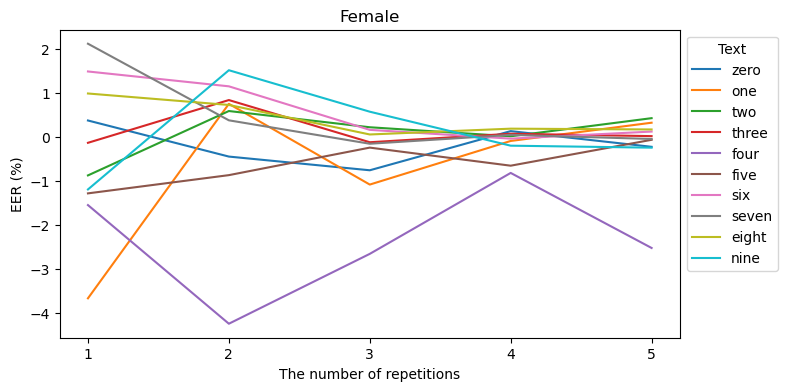

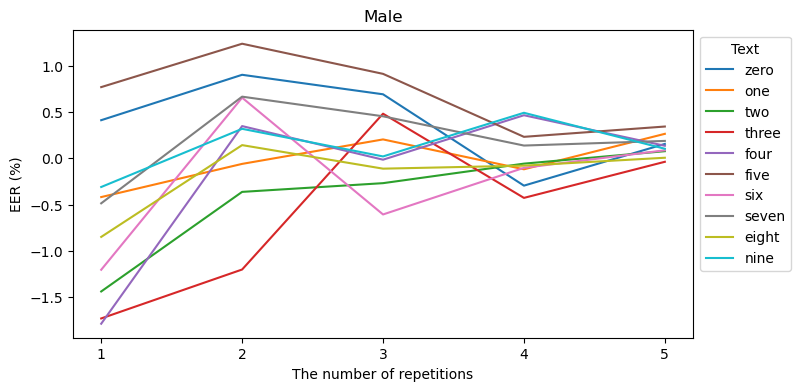

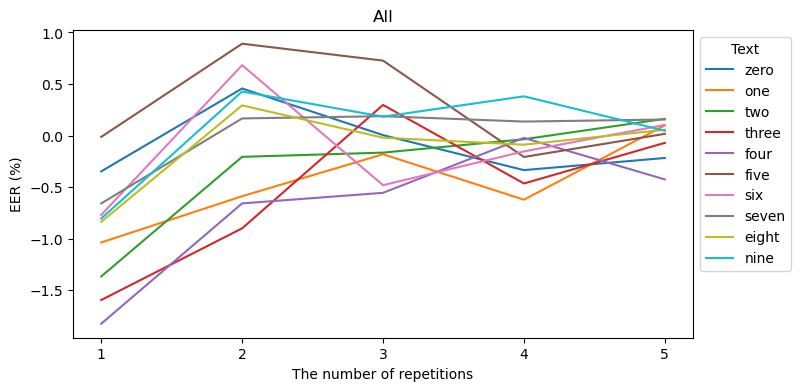

In [76]:
start_loop = 1
end_loop = 5
genders =  ['female', 'male', 'all']
metric = 'eer'
final_data = data

for _, gender in enumerate(genders):
    # plt.figure(figsize=(12,4))
    # name_set = list(final_data.keys())
    # for v in result['dev'][gender][metric].values():
    #     a.extend(v)
    # if gender=='all':
        # ax = plt.subplot2grid((2,4),(1,1), colspan=2)
    # ax = fig.add_subplot(2,3,i + 1)
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111)
    for i in range(0,10):
        try:
            ax.plot([j for j in range(start_loop, end_loop+1)],final_data[gender][i])
        except:
            ax.plot([j for j in range(start_loop, end_loop+1)],final_data[gender][str(i)])

        # box = ax.get_position()
        # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.set_xticks([ i for i in range(start_loop,end_loop+1)])
    ax.set_xlabel('The number of repetitions')
    # ax.set_ylim((min_-0.5,max_+0.5))
    if metric == 'eer':
        y_label = 'EER (%)'
    else:
        y_label = 'minDCF'

    ax.set_ylabel(y_label)
    ax.set_title(gender.capitalize())
    # ax.legend([DIGIT_MAPPING[i] for i in range(0,10)], loc='upper left', ncol=1, bbox_to_anchor=[1,1], title='Text')
    plt.legend([DIGIT_MAPPING[i] for i in range(0,10)], loc='upper left', ncol=1, bbox_to_anchor=[1,1], title='Text')
plt.show()

In [77]:
data = {
    'female':{},
    'male':{},
    'all':{}
}
for gender in ['female', 'male', 'all']:
    loss_array = []
    for digit in range(0,10):
        loss = np.array(results['1024']['eval'][gender]['eer'][str(digit)]) - np.array(results['128']['eval'][gender]['eer'][str(digit)])
        loss_array.append(loss)
    loss_array = np.array(loss_array)
    loss_array = np.mean(loss_array,axis=0)
    data[gender] = loss_array

In [78]:
data

{'female': array([-0.37755102,  0.03438095, -0.40484354, -0.13902494, -0.2087483 ]),
 'male': array([-0.70541723,  0.26559297,  0.17702948,  0.0250034 ,  0.13285488]),
 'all': array([-9.24903401e-01,  5.68371882e-02,  1.48752834e-04, -1.40907029e-01,
        -6.80907029e-03])}

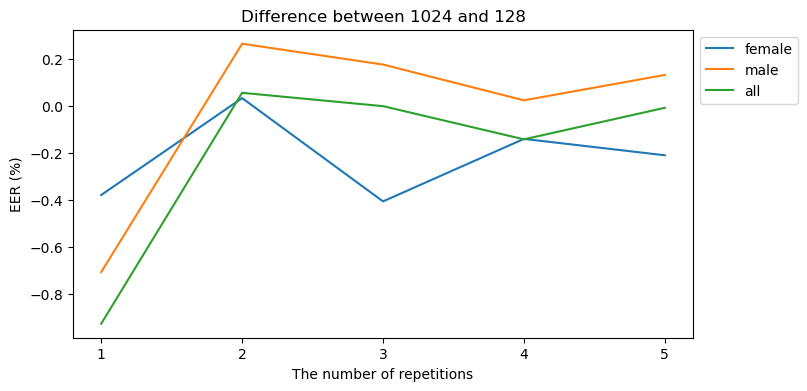

In [89]:
start_loop = 1
end_loop = 5
genders =  ['female', 'male', 'all']
metric = 'eer'
final_data = data
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
for _, gender in enumerate(genders):
    # plt.figure(figsize=(12,4))
    # name_set = list(final_data.keys())
    # for v in result['dev'][gender][metric].values():
    #     a.extend(v)
    # if gender=='all':
        # ax = plt.subplot2grid((2,4),(1,1), colspan=2)
    # ax = fig.add_subplot(2,3,i + 1)
    # fig = plt.figure(figsize=(8,4))
    # ax = fig.add_subplot(111)
    ax.plot([ i for i in range(start_loop,end_loop+1)],final_data[gender])
    # for i in range(0,10):
    #     try:
    #         ax.plot([j for j in range(start_loop, end_loop+1)],final_data[gender][i])
    #     except:
    #         ax.plot([j for j in range(start_loop, end_loop+1)],final_data[gender][str(i)])

        # box = ax.get_position()
        # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.set_xticks([ i for i in range(start_loop,end_loop+1)])
    ax.set_xlabel('The number of repetitions')
    # ax.set_ylim((min_-0.5,max_+0.5))
    if metric == 'eer':
        y_label = 'EER (%)'
    else:
        y_label = 'minDCF'

    ax.set_ylabel(y_label)
    
    # ax.legend([DIGIT_MAPPING[i] for i in range(0,10)], loc='upper left', ncol=1, bbox_to_anchor=[1,1], title='Text')
    # plt.legend([DIGIT_MAPPING[i] for i in range(0,10)], loc='upper left', ncol=1, bbox_to_anchor=[1,1], title='Text')
plt.legend(genders, loc='upper left', ncol=1, bbox_to_anchor=[1,1])
plt.title('Difference between 1024 and 128')
plt.show()

# Non-pretrained and pretrained techniques

In [13]:
PATH = 'sync_result'

## Gender dependent

In [14]:
channels = [128,1024]
techniques = ['non_pretrain', 'pretrain']
result = {}
for gender in ['all', 'female', 'male']:
    result[gender] = {}
    for c in channels:
        for tech in techniques:
            key = '%s_%s' % (c, tech)
            if tech == 'non_pretrain':
                files = glob.glob(os.path.join(PATH, tech, "%s_%s_exp*.csv"%(c,'non-pretrained')))
            else:
                files = glob.glob(os.path.join(PATH, tech, "%s_%s_exp*.csv"%(c,'pretrained')))
            df = pd.DataFrame()
            for f in files:
                df = pd.concat([df, pd.read_csv(f)], ignore_index=True)

            result[gender][key] = df.groupby(['phase', 'gender', 'loop'])['eer'].mean()['eval'][gender].to_list()    




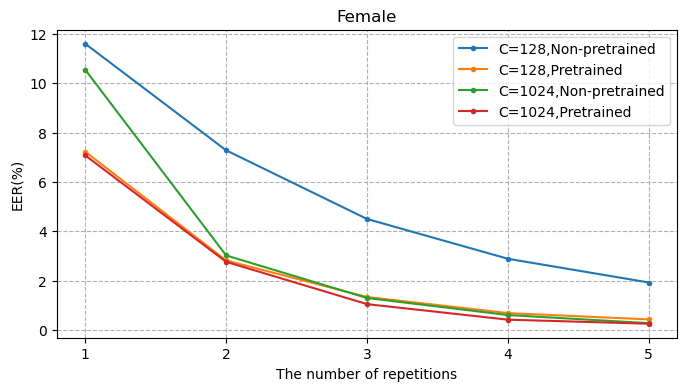

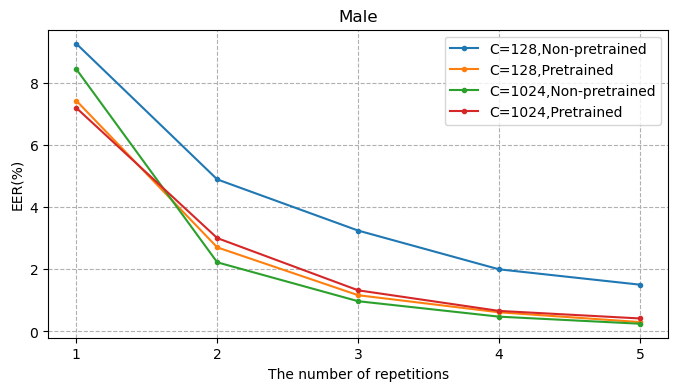

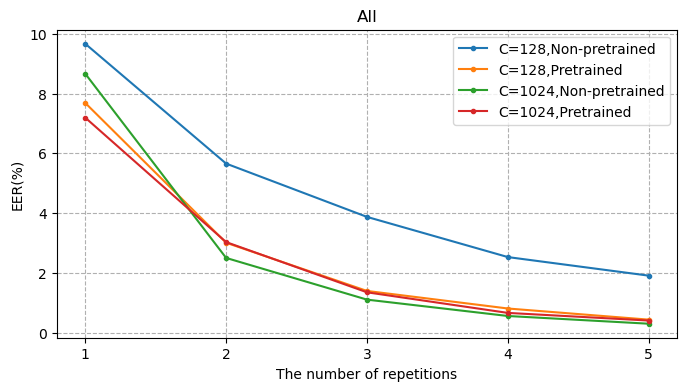

In [16]:
for gender in ['female', 'male', 'all']:
    data = result[gender]
    legends = []
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111)
    for k in data:
        leg = 'C=%s,%s'
        if 'non_pretrain' in k:
            tech_str = 'Non-pretrained'
        else:
            tech_str = 'Pretrained'
        
        C = k.split('_')[0]
        legends.append(leg%(C,tech_str))
        ax.plot([loop for loop in range(1,6)],data[k],marker='.')
    plt.title(gender.capitalize())
    plt.ylabel('EER(%)')
    plt.xlabel('The number of repetitions')
    plt.xticks([loop for loop in range(1,6)])
    plt.legend(legends)
    plt.grid(linestyle='--')
    plt.savefig('sync_result/images/1024_and_128_%s.png'%(gender))
    plt.show()
    



## Gender independent

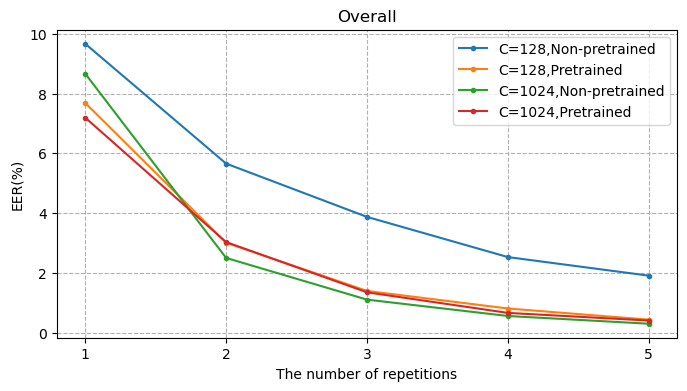

In [19]:
channels = [128,1024]
techniques = ['non_pretrain', 'pretrain']
result = {}
for c in channels:
    for tech in techniques:
        key = '%s_%s' % (c, tech)
        if tech == 'non_pretrain':
                files = glob.glob(os.path.join(PATH, tech, "%s_%s_exp*.csv"%(c,'non-pretrained')))
        else:
            files = glob.glob(os.path.join(PATH, tech, "%s_%s_exp*.csv"%(c,'pretrained')))
        df = pd.DataFrame()
        for f in files:
            df = pd.concat([df, pd.read_csv(f)], ignore_index=True)

        result[key] = df.groupby(['phase', 'gender', 'loop'])['eer'].mean()['eval'][gender].to_list()
legends = []
data = result
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
for k in data:
    leg = 'C=%s,%s'
    if 'non_pretrain' in k:
        tech_str = 'Non-pretrained'
    else:
        tech_str = 'Pretrained'
    
    C = k.split('_')[0]
    legends.append(leg%(C,tech_str))
    ax.plot([loop for loop in range(1,6)],data[k],marker='.')
plt.title('Overall')
plt.ylabel('EER(%)')
plt.xlabel('The number of repetitions')
plt.xticks([loop for loop in range(1,6)])
plt.legend(legends)
plt.grid(linestyle='--')
plt.savefig('sync_result/images/1024_and_128_overall.png')
plt.show()


# Visualization

In [20]:
def compute_average_result(files, type='json'):
    assert type in ['json', 'dataframe']
    if type == 'dataframe':
        df = pd.DataFrame()
        for f in files:
            df = pd.concat([df, pd.read_csv(f)], ignore_index=True)
        
            average = df.groupby(['phase', 'gender', 'text']).mean()

        return average
    elif type == 'json':
            result = {}
            for i, f in enumerate(files):
                result[i] = json.load(open(f,'r'))
            phases = ['eval']
            metrics = ['eer', 'minDCF']
            genders = ['female', 'male', 'all']
            final_result = {}
            # word = {}
            for phase in phases:
                final_result[phase] = {}
                # word[phase] = {}
                for gender in genders:
                    final_result[phase][gender] = {}
                    # word[phase][gender] = {}
                    for metric in metrics:
                        final_result[phase][gender][metric] = {}
                        # word[phase][gender][metric] = {}
                        for i in result[0][phase][gender][metric]:
                            temp = []
                            for exp in result:
                                try:
                                    temp.append(result[exp][phase][gender][metric][i])
                                except:
                                    temp.append(result[exp][phase][gender][metric][str(i)])
                            value = np.mean(temp, axis=0)
                            try:
                                final_result[phase][gender][metric][i] = list(value)
                            except: 
                                final_result[phase][gender][metric][i] = value
            return final_result            
    
    return None

In [22]:
def visualize_result(final_result,
                    path_to_save=None,
                    start_loop=1,
                    end_loop = 5,
                    genders =  ['female', 'male', 'all'],
                    metric = 'eer',
                    limit=True):
    if limit:
        a = []
        for gender in genders:
            for v in final_result['eval'][gender][metric].values():
                    a.extend(v)
            if len(a) == 0:
                continue
            min_ = min(a)
            max_ = max(a)

    for _, gender in enumerate(genders):
        # plt.figure(figsize=(12,4))
        name_set = list(final_result.keys())
        fig = plt.figure(figsize=(8,4))
        ax = fig.add_subplot(111)
        for idx,set in enumerate(name_set):
            set_result = final_result[set]
            # print(set_result[gender][metric])
            for i in range(0,10):
                try:
                    ax.plot([j for j in range(start_loop, end_loop+1)],set_result[gender][metric][i])
                except:
                    ax.plot([j for j in range(start_loop, end_loop+1)],set_result[gender][metric][str(i)])
        ax.set_xticks([ i for i in range(start_loop,end_loop+1)])
        ax.set_xlabel('The number of repetitions')
        if limit:
            ax.set_ylim((min_-0.5,max_+0.5))
        if metric == 'eer':
            y_label = 'EER (%)'
        else:
            y_label = 'minDCF'

        ax.set_ylabel(y_label)
        ax.set_title(gender.capitalize())
        ax.grid(linestyle='--')
        # ax.legend([DIGIT_MAPPING[i] for i in range(0,10)], loc='upper left', ncol=1, bbox_to_anchor=[1,1], title='Text')
        plt.legend([DIGIT_MAPPING[i] for i in range(0,10)], loc='upper left', ncol=1, bbox_to_anchor=[1,1], title='Text')
        if path_to_save is not None:
            plt.savefig(path_to_save + '_%s.png'%(gender))
        plt.show()
        

sync_result/images/1024_non_pretrain
1024_non_pretrain


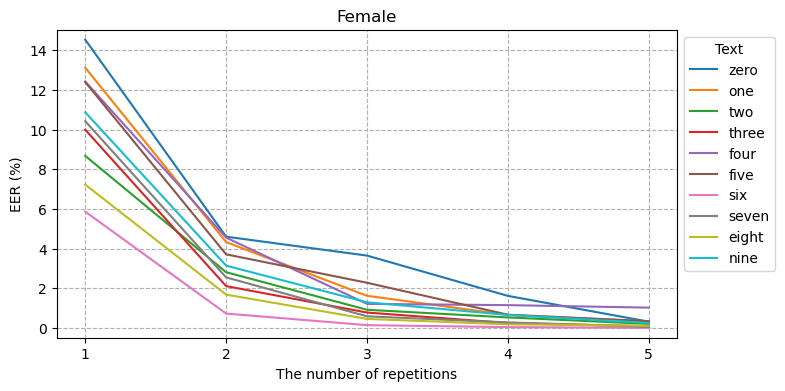

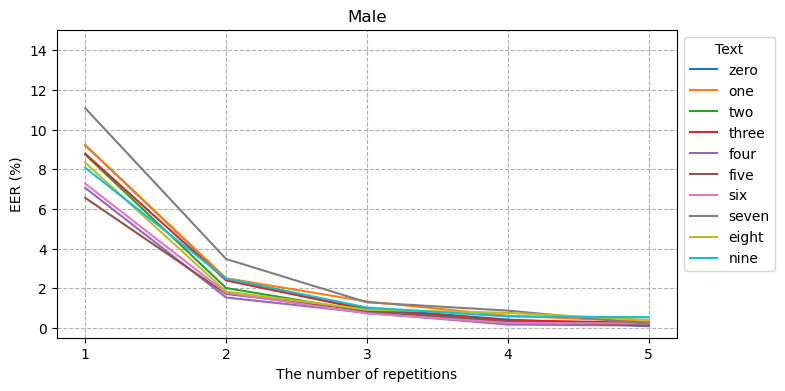

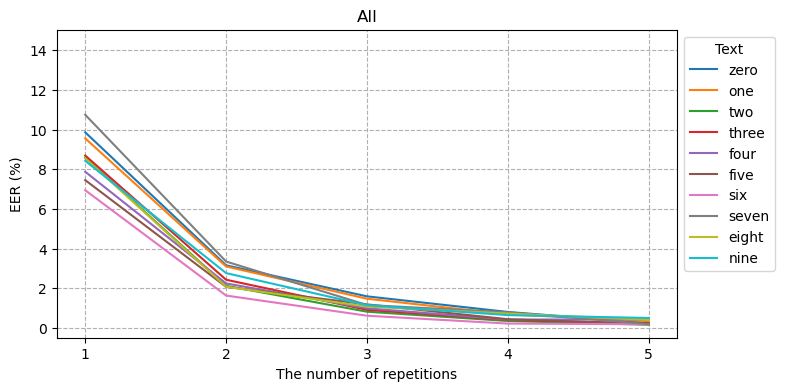

sync_result/images/1024_pretrain
1024_pretrain


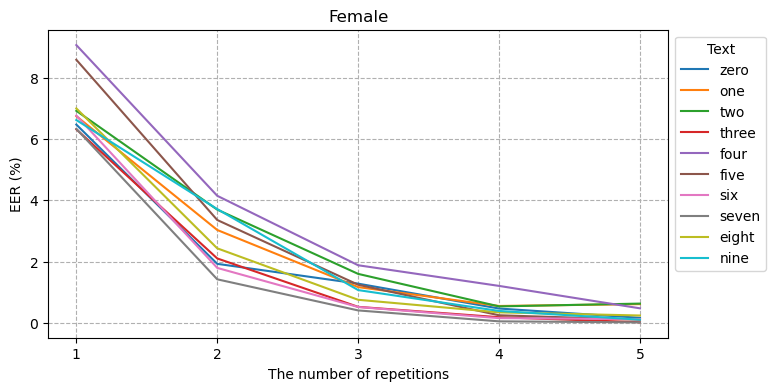

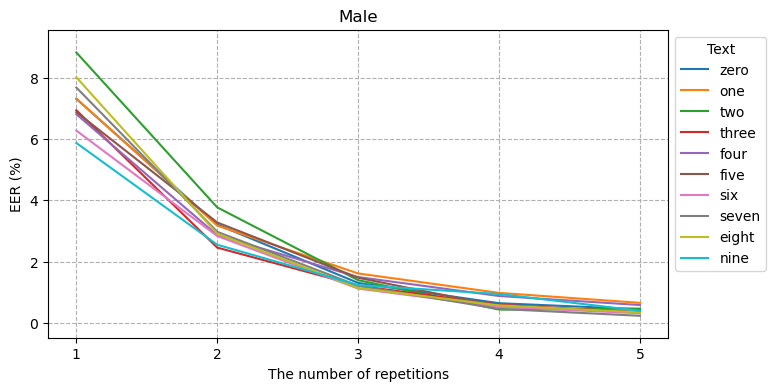

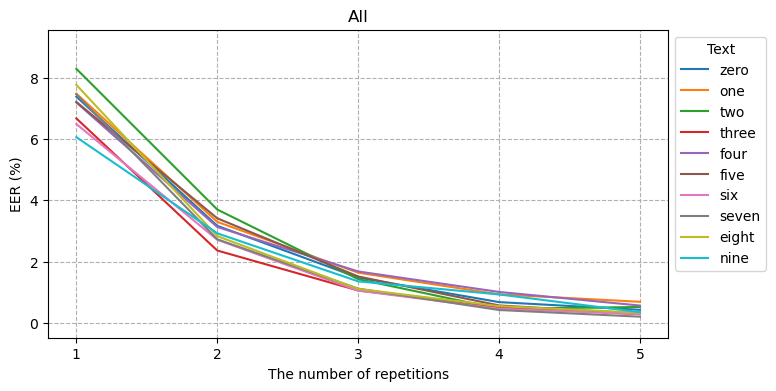

sync_result/images/128_non_pretrain
128_non_pretrain


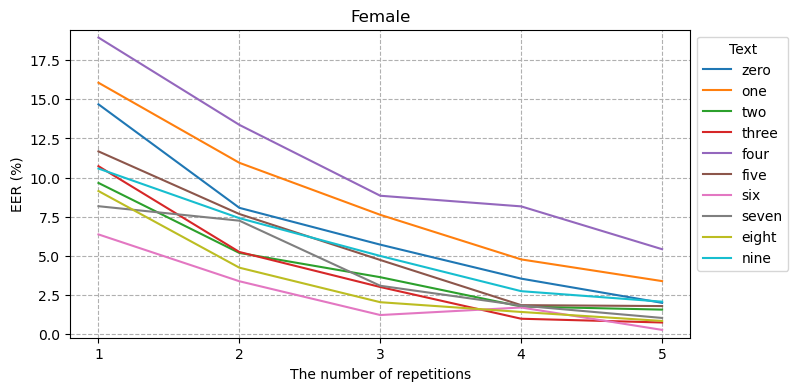

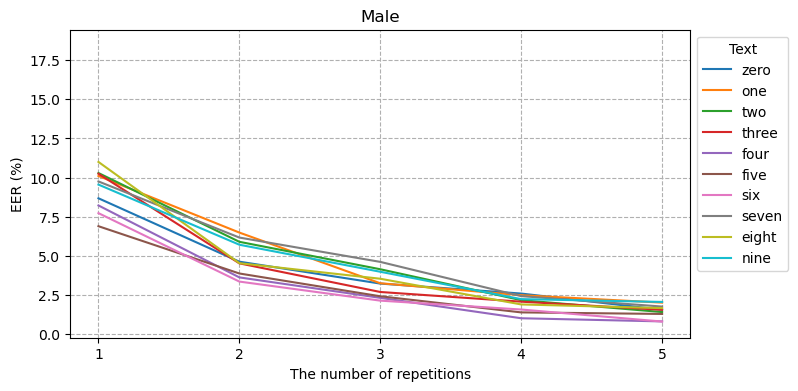

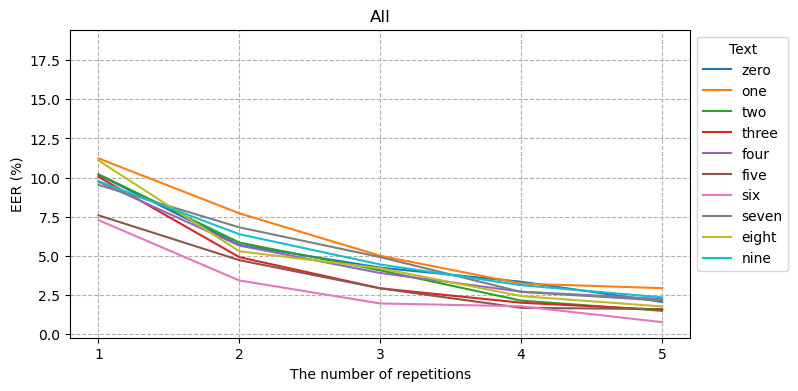

sync_result/images/128_pretrain
128_pretrain


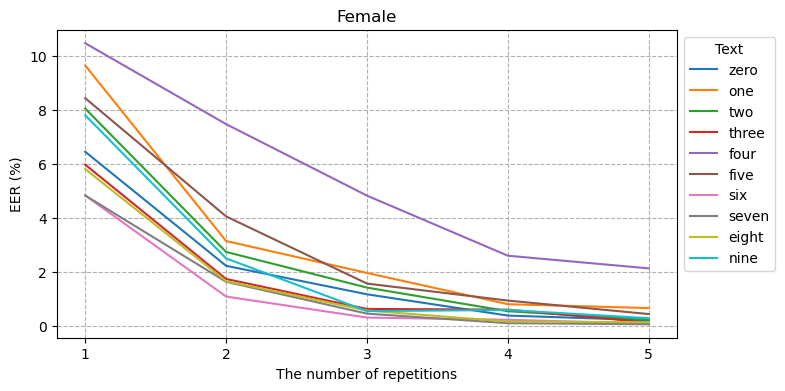

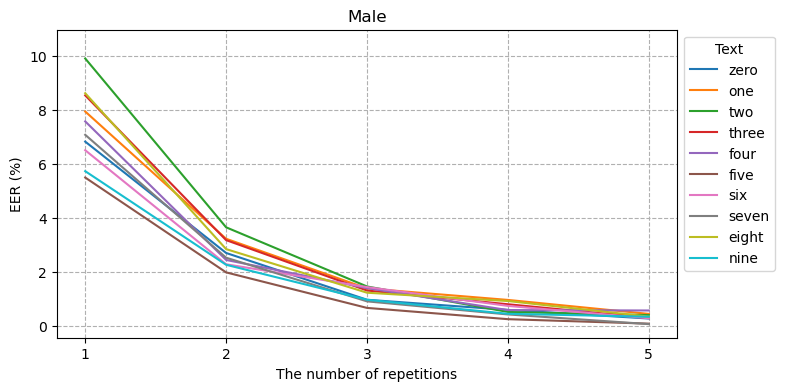

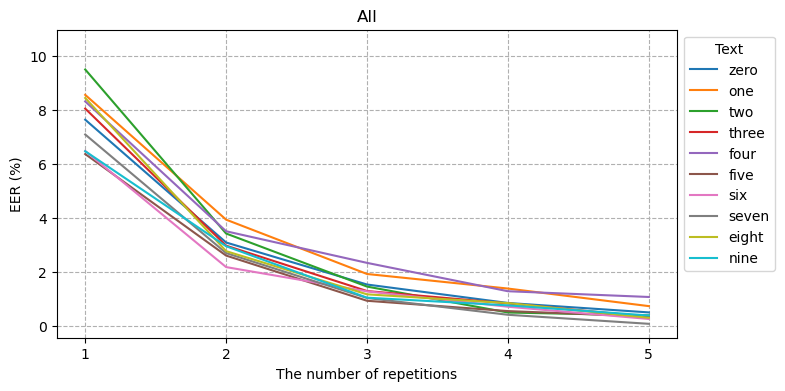

In [24]:
channels = [1024,128]
techs = ['non_pretrain','pretrain']
for c in channels:
    for tech in techniques:
        key = '%s_%s' % (c, tech)
        if tech == 'non_pretrain':
            files = glob.glob(os.path.join(PATH, tech, "%s_%s_exp*.json"%(c,'non-pretrained')))
        else:
            files = glob.glob(os.path.join(PATH, tech, "%s_%s_exp*.json"%(c,'pretrained')))
        path_to_save = os.path.join(PATH,'images',key)
        print(path_to_save)
        average = compute_average_result(files,
                                         type='json')
        print(key)
        visualize_result(average,path_to_save=path_to_save,limit=True)

In [25]:
def draw_bar_chart(filter,path_to_save=None):
    param = [-0.2, 0, +0.2]
    plt.figure(figsize=(12,6))
    plt.grid(zorder=-1,linestyle='--')
    # data_vis = dict(sorted(filter[gender][metric].items(), key=lambda item: item[1]))
    plt.bar(np.arange(len(filter['female']['eer'])) - 0.2, list(filter['female']['eer'].values()),width=0.2)
    plt.bar(np.arange(len(filter['male']['eer'])), list(filter['male']['eer'].values()),width=0.2)
    plt.bar(np.arange(len(filter['all']['eer']))  +0.2, list(filter['all']['eer'].values()),width=0.2)
    plt.xlabel('Text')
    plt.ylabel('EER (%)')
    plt.legend(['Female', 'Male', 'All'])
    plt.xticks(ticks=range(len(filter['female']['eer'])),labels=[ '_'.join([DIGIT_MAPPING[int(i)] for i in text.split('_')]) for text in list(filter['female']['eer'].keys())],fontsize=8, rotation=60)
    
    plt.show()

In [26]:
def get_loop_from_average(average,loop,digits):
    result = {}
    for phase in average:
        result[phase] = {}
        for gender in average[phase]:
            result[phase][gender]= {}
            for metric in average[phase][gender]:
                result[phase][gender][metric] = {}
                for text in average[phase][gender][metric]:
                    if text in digits:
                        result[phase][gender][metric][text] = average[phase][gender][metric][text][loop-1]
    return result

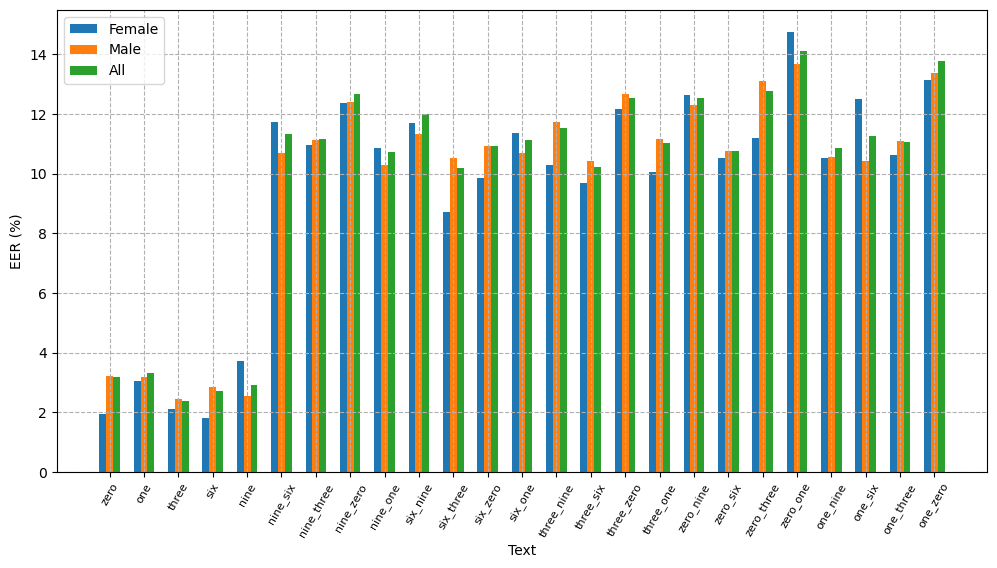

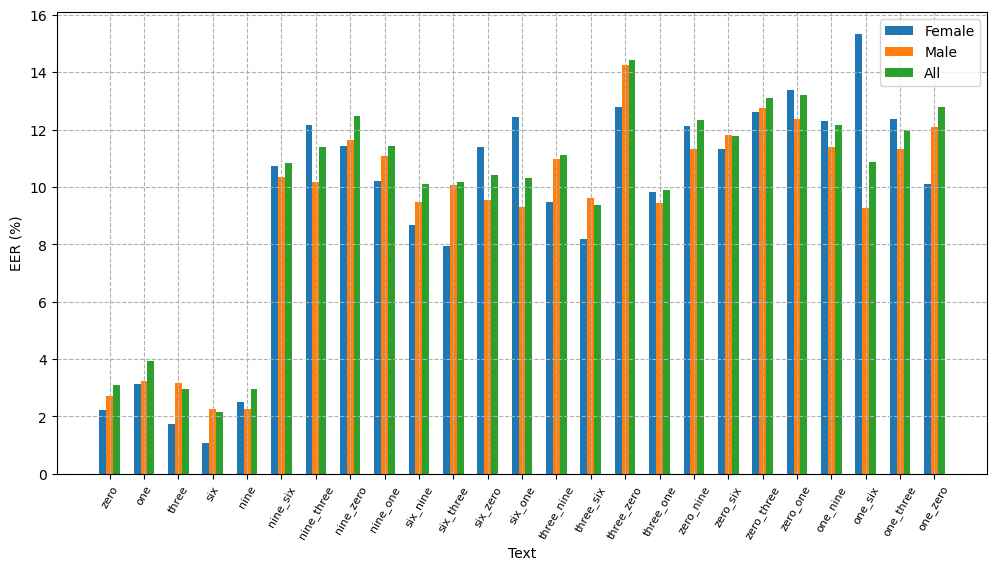

In [246]:
# Experiments
loop = 1
PATH = 'sync_result'
channels = [1024,128]
techniques = ['pretrain']
genders = ['female', 'male', 'all']
phases = ['eval']
digits = ['9', '6', '3', '0','1']
words = list(permutations(digits,r=2))
text = digits + ['_'.join(word) for word in words]
for c in channels:
    for tech in techniques:
        key = '%s_%s' % (c, tech)
        files = glob.glob(os.path.join(PATH, tech, "%s_%s_exp*.json"%(c,'experiment')))
        print(files)
        # path_to_save = os.path.join(PATH,'images',key)
        average_1 = compute_average_result(files, type='json')
        
        
        files = glob.glob(os.path.join(PATH, tech, "%s_%s_exp*.json"%(c,'pretrained')))
        average_2 = compute_average_result(files,type='json')
        loop2 = get_loop_from_average(average_2,2,digits)
        
        for gender in ['female', 'male', 'all']:
            for digit in sorted(digits):
                loop2['eval'][gender]['eer'].update(average_1['eval'][gender]['eer'])
                loop2['eval'][gender]['minDCF'].update(average_1['eval'][gender]['minDCF'])
                
        # print(average_1)
        draw_bar_chart(loop2['eval'])
        # draw_bar_chart(get_loop_from_average(average_2,1)['eval'])
        # print(average_2)
        
